In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
!pip install yfinance
import yfinance as yf
%matplotlib inline

  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=8f38e3d252d9898940cc6a4d271e6a851a4de89b7a5a78bbbbf4ea56a94277e6
  Stored in directory: c:\users\micha\appdata\local\pip\cache\wheels\21\c9\66\b41c847de65c7985db52ec21d59996841598b8b0e93f2b9500
Successfully built multitasking


# Download and Start Analysis

In [2]:
start = "2020-01-01"
end = "2022-03-11"
spx = yf.download('SPCX',start,end)


[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Open Price')

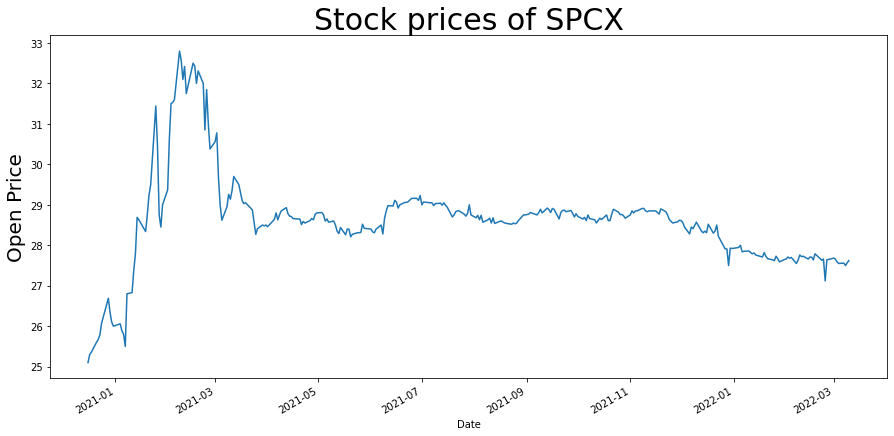

In [74]:
spx['Open'].plot(label = 'SPCX',figsize = (15,7))
plt.title('Stock prices of SPCX',fontsize = 30)
plt.ylabel('Open Price', fontsize = 20)

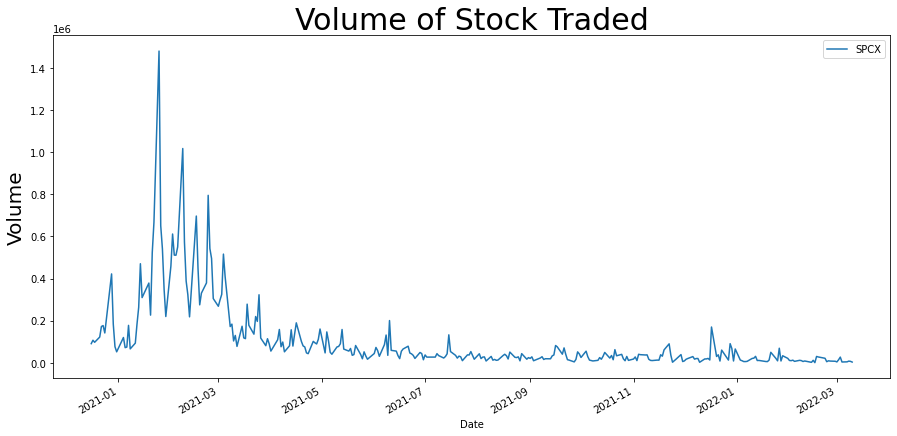

In [75]:
spx['Volume'].plot(label = 'SPCX',figsize=(15,7))
plt.title('Volume of Stock Traded', fontsize = 30)
plt.ylabel('Volume',fontsize = 20)
plt.legend()

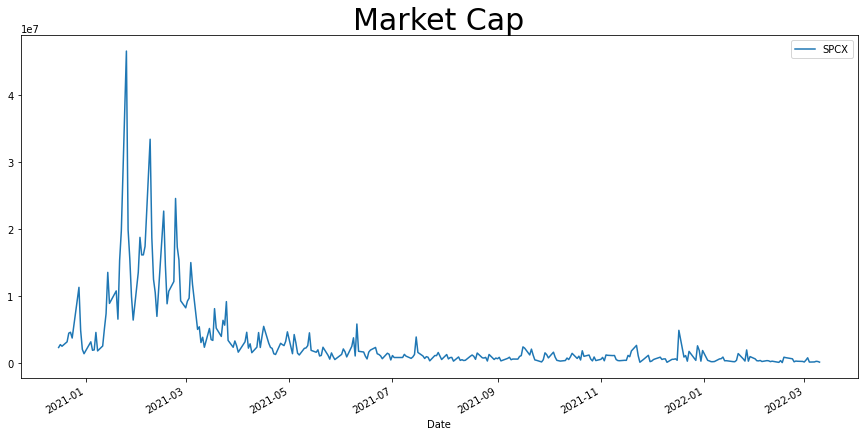

In [76]:
# Market Capitlization
spx['MarktCap'] = spx['Open'] * spx['Volume']
spx['MarktCap'].plot(label = 'SPCX',figsize = (15,7))
plt.title('Market Cap',fontsize = 30)

plt.legend()

<AxesSubplot:title={'center':'Rolling Mean and Open'}, xlabel='Date'>

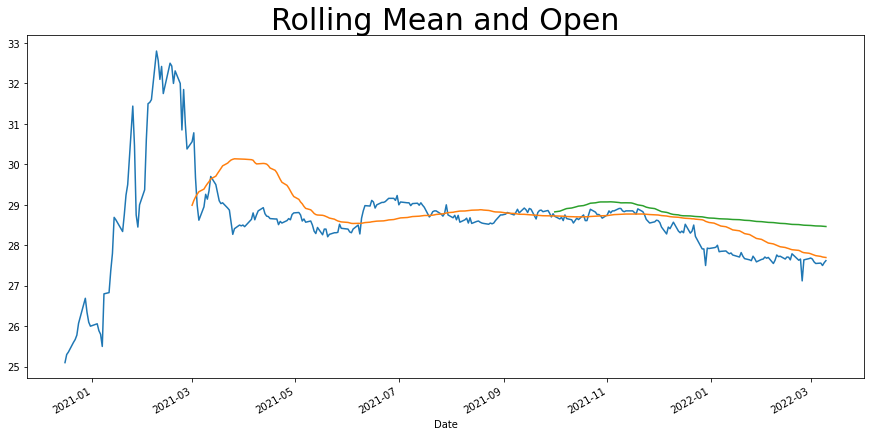

In [77]:
spx['MA50'] = spx['Open'].rolling(50).mean()
spx['MA200'] = spx['Open'].rolling(200).mean()
spx['Open'].plot(figsize =(15,7))
plt.title('Rolling Mean and Open',fontsize = 30)
spx['MA50'].plot()
spx['MA200'].plot()

array([[<AxesSubplot:xlabel='SPXOpen', ylabel='SPXOpen'>]], dtype=object)

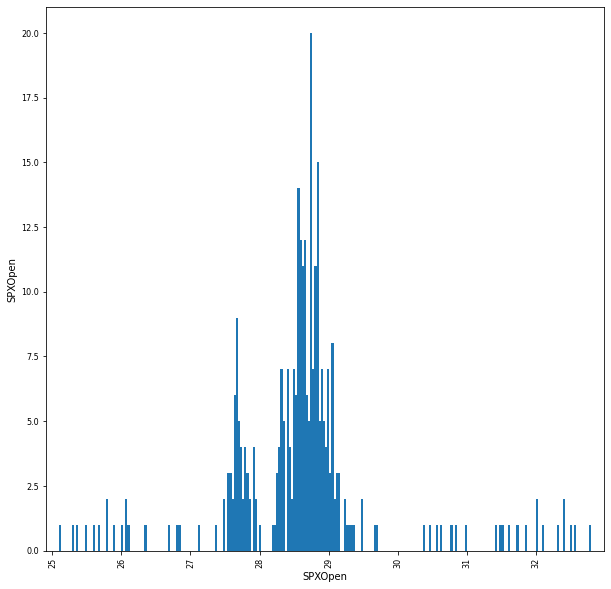

In [78]:
data = pd.concat([spx['Open']],axis = 1)
data.columns = ['SPXOpen']
scatter_matrix(data,figsize=(10,10),hist_kwds = {'bins':250})

Text(0.5, 1.0, 'Volatility')

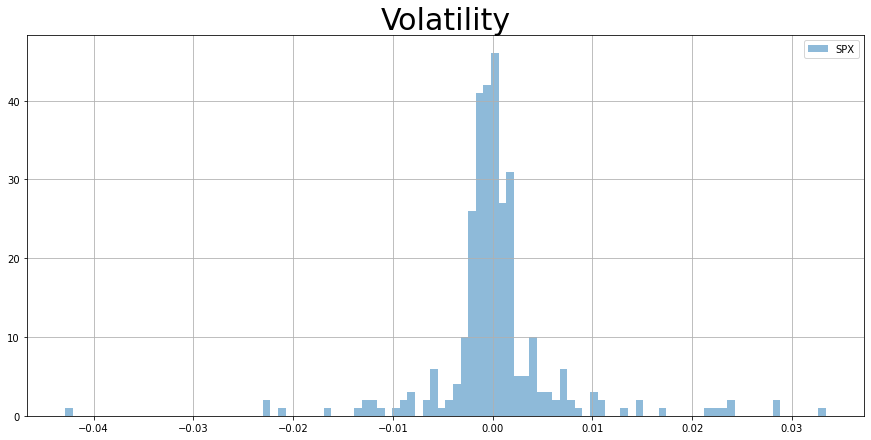

In [79]:
# Volatitlity
spx['returns'] = (spx['Close']/spx['Close'].shift(1)) -1
spx['returns'].hist(bins = 100, label = 'SPX', alpha = 0.5, figsize = (15,7))
plt.legend()
plt.title('Volatility', fontsize = 30)

# Modeling for Forecast

In [30]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import random

In [31]:
# set seed, so we can get the same results  after rerunning
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [35]:

def load_data(ticker=('SPCX'), n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result
print(load_data)

<function load_data at 0x000002153C0D78B0>


In [36]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model
    

In [60]:
import time
# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 400
# Amazon stock market
ticker = "SPCX"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [61]:
# create these folders if they do not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [62]:
# load the data
data = load_data(ticker,N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    use_multiprocessing = True,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/400
4/4 [==============================] - ETA: 0s - loss: 0.0644 - mean_absolute_error: 0.2866
Epoch 00001: val_loss improved from inf to 0.00500, saving model to results\2022-03-24_SPCX-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
4/4 [==============================] - 4s 977ms/step - loss: 0.0644 - mean_absolute_error: 0.2866 - val_loss: 0.0050 - val_mean_absolute_error: 0.0919
Epoch 2/400
4/4 [==============================] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.1497
Epoch 00002: val_loss did not improve from 0.00500
4/4 [==============================] - 1s 155ms/step - loss: 0.0132 - mean_absolute_error: 0.1497 - val_loss: 0.0101 - val_mean_absolute_error: 0.1361
Epoch 3/400
4/4 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0942
Epoch 00003: val_loss did not improve from 0.00500
4/4 [==============================] - 1s 154ms/step - loss: 0.0062 - mean_absolute_error: 0.0942 - val_loss: 0.0053 -

Epoch 22/400
4/4 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0402
Epoch 00022: val_loss improved from 0.00076 to 0.00072, saving model to results\2022-03-24_SPCX-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
4/4 [==============================] - 1s 166ms/step - loss: 0.0015 - mean_absolute_error: 0.0402 - val_loss: 7.2023e-04 - val_mean_absolute_error: 0.0280
Epoch 23/400
4/4 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0402
Epoch 00023: val_loss improved from 0.00072 to 0.00070, saving model to results\2022-03-24_SPCX-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
4/4 [==============================] - 1s 173ms/step - loss: 0.0013 - mean_absolute_error: 0.0402 - val_loss: 6.9560e-04 - val_mean_absolute_error: 0.0277
Epoch 24/400
4/4 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0435
Epoch 00024: val_loss did not impro

4/4 [==============================] - 1s 160ms/step - loss: 0.0013 - mean_absolute_error: 0.0399 - val_loss: 5.8326e-04 - val_mean_absolute_error: 0.0264
Epoch 45/400
4/4 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0389
Epoch 00045: val_loss improved from 0.00058 to 0.00058, saving model to results\2022-03-24_SPCX-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
4/4 [==============================] - 1s 160ms/step - loss: 0.0011 - mean_absolute_error: 0.0389 - val_loss: 5.7582e-04 - val_mean_absolute_error: 0.0256
Epoch 46/400
4/4 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0392
Epoch 00046: val_loss improved from 0.00058 to 0.00058, saving model to results\2022-03-24_SPCX-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
4/4 [==============================] - 1s 155ms/step - loss: 0.0013 - mean_absolute_error: 0.0392 - val_loss: 5.7532e-04 - val_mean_absolute

4/4 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0386   
Epoch 00068: val_loss improved from 0.00054 to 0.00054, saving model to results\2022-03-24_SPCX-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
4/4 [==============================] - 1s 157ms/step - loss: 0.0011 - mean_absolute_error: 0.0386 - val_loss: 5.4200e-04 - val_mean_absolute_error: 0.0261
Epoch 69/400
4/4 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0389
Epoch 00069: val_loss improved from 0.00054 to 0.00053, saving model to results\2022-03-24_SPCX-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
4/4 [==============================] - 1s 162ms/step - loss: 0.0012 - mean_absolute_error: 0.0389 - val_loss: 5.3013e-04 - val_mean_absolute_error: 0.0245
Epoch 70/400
4/4 [==============================] - ETA: 0s - loss: 9.7767e-04 - mean_absolute_error: 0.0338
Epoch 00070: val_loss did not improve fro

Epoch 92/400
4/4 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0395
Epoch 00092: val_loss did not improve from 0.00049
4/4 [==============================] - 1s 158ms/step - loss: 0.0012 - mean_absolute_error: 0.0395 - val_loss: 8.6251e-04 - val_mean_absolute_error: 0.0302
Epoch 93/400
4/4 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0346    
Epoch 00093: val_loss did not improve from 0.00049
4/4 [==============================] - 1s 154ms/step - loss: 0.0010 - mean_absolute_error: 0.0346 - val_loss: 6.1316e-04 - val_mean_absolute_error: 0.0297
Epoch 94/400
4/4 [==============================] - ETA: 0s - loss: 9.6730e-04 - mean_absolute_error: 0.0352
Epoch 00094: val_loss did not improve from 0.00049
4/4 [==============================] - 1s 155ms/step - loss: 9.6730e-04 - mean_absolute_error: 0.0352 - val_loss: 9.2978e-04 - val_mean_absolute_error: 0.0326
Epoch 95/400
4/4 [==============================] - ETA

Epoch 118/400
4/4 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0353  
Epoch 00118: val_loss did not improve from 0.00049
4/4 [==============================] - 1s 155ms/step - loss: 0.0011 - mean_absolute_error: 0.0353 - val_loss: 5.6076e-04 - val_mean_absolute_error: 0.0286
Epoch 119/400
4/4 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0391
Epoch 00119: val_loss did not improve from 0.00049
4/4 [==============================] - 1s 156ms/step - loss: 0.0011 - mean_absolute_error: 0.0391 - val_loss: 6.0219e-04 - val_mean_absolute_error: 0.0245
Epoch 120/400
4/4 [==============================] - ETA: 0s - loss: 9.7830e-04 - mean_absolute_error: 0.0344
Epoch 00120: val_loss did not improve from 0.00049
4/4 [==============================] - 1s 161ms/step - loss: 9.7830e-04 - mean_absolute_error: 0.0344 - val_loss: 8.2501e-04 - val_mean_absolute_error: 0.0352
Epoch 121/400
4/4 [==============================] - E

Epoch 143/400
4/4 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0361
Epoch 00143: val_loss did not improve from 0.00047
4/4 [==============================] - 1s 160ms/step - loss: 0.0010 - mean_absolute_error: 0.0361 - val_loss: 5.5267e-04 - val_mean_absolute_error: 0.0285
Epoch 144/400
4/4 [==============================] - ETA: 0s - loss: 9.5235e-04 - mean_absolute_error: 0.0348
Epoch 00144: val_loss did not improve from 0.00047
4/4 [==============================] - 1s 155ms/step - loss: 9.5235e-04 - mean_absolute_error: 0.0348 - val_loss: 6.2326e-04 - val_mean_absolute_error: 0.0252
Epoch 145/400
4/4 [==============================] - ETA: 0s - loss: 9.0841e-04 - mean_absolute_error: 0.0337
Epoch 00145: val_loss did not improve from 0.00047
4/4 [==============================] - 1s 154ms/step - loss: 9.0841e-04 - mean_absolute_error: 0.0337 - val_loss: 5.2635e-04 - val_mean_absolute_error: 0.0276
Epoch 146/400
4/4 [=============================

Epoch 169/400
4/4 [==============================] - ETA: 0s - loss: 8.5303e-04 - mean_absolute_error: 0.0334
Epoch 00169: val_loss did not improve from 0.00047
4/4 [==============================] - 1s 156ms/step - loss: 8.5303e-04 - mean_absolute_error: 0.0334 - val_loss: 6.6990e-04 - val_mean_absolute_error: 0.0267
Epoch 170/400
4/4 [==============================] - ETA: 0s - loss: 9.9225e-04 - mean_absolute_error: 0.0339
Epoch 00170: val_loss did not improve from 0.00047
4/4 [==============================] - 1s 157ms/step - loss: 9.9225e-04 - mean_absolute_error: 0.0339 - val_loss: 4.7942e-04 - val_mean_absolute_error: 0.0258
Epoch 171/400
4/4 [==============================] - ETA: 0s - loss: 9.2698e-04 - mean_absolute_error: 0.0344
Epoch 00171: val_loss did not improve from 0.00047
4/4 [==============================] - 1s 153ms/step - loss: 9.2698e-04 - mean_absolute_error: 0.0344 - val_loss: 6.2828e-04 - val_mean_absolute_error: 0.0255
Epoch 172/400
4/4 [=====================

4/4 [==============================] - 1s 159ms/step - loss: 9.5815e-04 - mean_absolute_error: 0.0355 - val_loss: 5.1898e-04 - val_mean_absolute_error: 0.0241
Epoch 195/400
4/4 [==============================] - ETA: 0s - loss: 9.2047e-04 - mean_absolute_error: 0.0331
Epoch 00195: val_loss did not improve from 0.00046
4/4 [==============================] - 1s 160ms/step - loss: 9.2047e-04 - mean_absolute_error: 0.0331 - val_loss: 5.5612e-04 - val_mean_absolute_error: 0.0248
Epoch 196/400
4/4 [==============================] - ETA: 0s - loss: 7.8238e-04 - mean_absolute_error: 0.0307
Epoch 00196: val_loss did not improve from 0.00046
4/4 [==============================] - 1s 154ms/step - loss: 7.8238e-04 - mean_absolute_error: 0.0307 - val_loss: 4.8266e-04 - val_mean_absolute_error: 0.0261
Epoch 197/400
4/4 [==============================] - ETA: 0s - loss: 8.3292e-04 - mean_absolute_error: 0.0327
Epoch 00197: val_loss did not improve from 0.00046
4/4 [==============================] - 1

4/4 [==============================] - ETA: 0s - loss: 8.5726e-04 - mean_absolute_error: 0.0331
Epoch 00220: val_loss did not improve from 0.00046
4/4 [==============================] - 1s 163ms/step - loss: 8.5726e-04 - mean_absolute_error: 0.0331 - val_loss: 4.9294e-04 - val_mean_absolute_error: 0.0240
Epoch 221/400
4/4 [==============================] - ETA: 0s - loss: 7.8665e-04 - mean_absolute_error: 0.0320
Epoch 00221: val_loss did not improve from 0.00046
4/4 [==============================] - 1s 165ms/step - loss: 7.8665e-04 - mean_absolute_error: 0.0320 - val_loss: 4.6593e-04 - val_mean_absolute_error: 0.0240
Epoch 222/400
4/4 [==============================] - ETA: 0s - loss: 9.4977e-04 - mean_absolute_error: 0.0355
Epoch 00222: val_loss did not improve from 0.00046
4/4 [==============================] - 1s 155ms/step - loss: 9.4977e-04 - mean_absolute_error: 0.0355 - val_loss: 4.9274e-04 - val_mean_absolute_error: 0.0239
Epoch 223/400
4/4 [==============================] - E

Epoch 245/400
4/4 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0378
Epoch 00245: val_loss did not improve from 0.00042
4/4 [==============================] - 1s 160ms/step - loss: 0.0012 - mean_absolute_error: 0.0378 - val_loss: 5.1639e-04 - val_mean_absolute_error: 0.0261
Epoch 246/400
4/4 [==============================] - ETA: 0s - loss: 7.8109e-04 - mean_absolute_error: 0.0310
Epoch 00246: val_loss did not improve from 0.00042
4/4 [==============================] - 1s 165ms/step - loss: 7.8109e-04 - mean_absolute_error: 0.0310 - val_loss: 5.2628e-04 - val_mean_absolute_error: 0.0246
Epoch 247/400
4/4 [==============================] - ETA: 0s - loss: 8.4840e-04 - mean_absolute_error: 0.0325
Epoch 00247: val_loss did not improve from 0.00042
4/4 [==============================] - 1s 163ms/step - loss: 8.4840e-04 - mean_absolute_error: 0.0325 - val_loss: 4.8271e-04 - val_mean_absolute_error: 0.0233
Epoch 248/400
4/4 [=============================

Epoch 271/400
4/4 [==============================] - ETA: 0s - loss: 9.4181e-04 - mean_absolute_error: 0.0354
Epoch 00271: val_loss did not improve from 0.00037
4/4 [==============================] - 1s 154ms/step - loss: 9.4181e-04 - mean_absolute_error: 0.0354 - val_loss: 6.5052e-04 - val_mean_absolute_error: 0.0268
Epoch 272/400
4/4 [==============================] - ETA: 0s - loss: 7.5651e-04 - mean_absolute_error: 0.0309
Epoch 00272: val_loss did not improve from 0.00037
4/4 [==============================] - 1s 155ms/step - loss: 7.5651e-04 - mean_absolute_error: 0.0309 - val_loss: 5.1012e-04 - val_mean_absolute_error: 0.0270
Epoch 273/400
4/4 [==============================] - ETA: 0s - loss: 9.7640e-04 - mean_absolute_error: 0.0366
Epoch 00273: val_loss did not improve from 0.00037
4/4 [==============================] - 1s 160ms/step - loss: 9.7640e-04 - mean_absolute_error: 0.0366 - val_loss: 4.5423e-04 - val_mean_absolute_error: 0.0235
Epoch 274/400
4/4 [=====================

4/4 [==============================] - ETA: 0s - loss: 7.2009e-04 - mean_absolute_error: 0.0293
Epoch 00296: val_loss did not improve from 0.00036
4/4 [==============================] - 1s 156ms/step - loss: 7.2009e-04 - mean_absolute_error: 0.0293 - val_loss: 3.7717e-04 - val_mean_absolute_error: 0.0216
Epoch 297/400
4/4 [==============================] - ETA: 0s - loss: 7.5377e-04 - mean_absolute_error: 0.0306
Epoch 00297: val_loss did not improve from 0.00036
4/4 [==============================] - 1s 158ms/step - loss: 7.5377e-04 - mean_absolute_error: 0.0306 - val_loss: 3.8684e-04 - val_mean_absolute_error: 0.0223
Epoch 298/400
4/4 [==============================] - ETA: 0s - loss: 6.2255e-04 - mean_absolute_error: 0.0286
Epoch 00298: val_loss did not improve from 0.00036
4/4 [==============================] - 1s 154ms/step - loss: 6.2255e-04 - mean_absolute_error: 0.0286 - val_loss: 6.7862e-04 - val_mean_absolute_error: 0.0306
Epoch 299/400
4/4 [==============================] - E

4/4 [==============================] - ETA: 0s - loss: 7.5789e-04 - mean_absolute_error: 0.0322
Epoch 00321: val_loss did not improve from 0.00035
4/4 [==============================] - 1s 161ms/step - loss: 7.5789e-04 - mean_absolute_error: 0.0322 - val_loss: 7.0123e-04 - val_mean_absolute_error: 0.0296
Epoch 322/400
4/4 [==============================] - ETA: 0s - loss: 8.4232e-04 - mean_absolute_error: 0.0316
Epoch 00322: val_loss did not improve from 0.00035
4/4 [==============================] - 1s 157ms/step - loss: 8.4232e-04 - mean_absolute_error: 0.0316 - val_loss: 5.8593e-04 - val_mean_absolute_error: 0.0284
Epoch 323/400
4/4 [==============================] - ETA: 0s - loss: 8.6227e-04 - mean_absolute_error: 0.0334
Epoch 00323: val_loss did not improve from 0.00035
4/4 [==============================] - 1s 156ms/step - loss: 8.6227e-04 - mean_absolute_error: 0.0334 - val_loss: 5.6753e-04 - val_mean_absolute_error: 0.0256
Epoch 324/400
4/4 [==============================] - E

Epoch 346/400
4/4 [==============================] - ETA: 0s - loss: 8.2353e-04 - mean_absolute_error: 0.0331
Epoch 00346: val_loss did not improve from 0.00031
4/4 [==============================] - 1s 155ms/step - loss: 8.2353e-04 - mean_absolute_error: 0.0331 - val_loss: 3.2086e-04 - val_mean_absolute_error: 0.0209
Epoch 347/400
4/4 [==============================] - ETA: 0s - loss: 6.0689e-04 - mean_absolute_error: 0.0274
Epoch 00347: val_loss did not improve from 0.00031
4/4 [==============================] - 1s 154ms/step - loss: 6.0689e-04 - mean_absolute_error: 0.0274 - val_loss: 4.7219e-04 - val_mean_absolute_error: 0.0261
Epoch 348/400
4/4 [==============================] - ETA: 0s - loss: 6.8457e-04 - mean_absolute_error: 0.0292
Epoch 00348: val_loss did not improve from 0.00031
4/4 [==============================] - 1s 156ms/step - loss: 6.8457e-04 - mean_absolute_error: 0.0292 - val_loss: 3.8154e-04 - val_mean_absolute_error: 0.0222
Epoch 349/400
4/4 [=====================

4/4 [==============================] - 1s 161ms/step - loss: 5.9582e-04 - mean_absolute_error: 0.0276 - val_loss: 8.2674e-04 - val_mean_absolute_error: 0.0346
Epoch 371/400
4/4 [==============================] - ETA: 0s - loss: 6.8079e-04 - mean_absolute_error: 0.0301
Epoch 00371: val_loss did not improve from 0.00027
4/4 [==============================] - 1s 164ms/step - loss: 6.8079e-04 - mean_absolute_error: 0.0301 - val_loss: 4.7265e-04 - val_mean_absolute_error: 0.0252
Epoch 372/400
4/4 [==============================] - ETA: 0s - loss: 7.3565e-04 - mean_absolute_error: 0.0307
Epoch 00372: val_loss did not improve from 0.00027
4/4 [==============================] - 1s 158ms/step - loss: 7.3565e-04 - mean_absolute_error: 0.0307 - val_loss: 3.5685e-04 - val_mean_absolute_error: 0.0212
Epoch 373/400
4/4 [==============================] - ETA: 0s - loss: 5.3781e-04 - mean_absolute_error: 0.0260
Epoch 00373: val_loss did not improve from 0.00027
4/4 [==============================] - 1

4/4 [==============================] - 1s 171ms/step - loss: 9.2041e-04 - mean_absolute_error: 0.0350 - val_loss: 0.0011 - val_mean_absolute_error: 0.0398
Epoch 396/400
4/4 [==============================] - ETA: 0s - loss: 7.4966e-04 - mean_absolute_error: 0.0306
Epoch 00396: val_loss did not improve from 0.00023
4/4 [==============================] - 1s 170ms/step - loss: 7.4966e-04 - mean_absolute_error: 0.0306 - val_loss: 4.3642e-04 - val_mean_absolute_error: 0.0246
Epoch 397/400
4/4 [==============================] - ETA: 0s - loss: 6.9416e-04 - mean_absolute_error: 0.0301
Epoch 00397: val_loss did not improve from 0.00023
4/4 [==============================] - 1s 156ms/step - loss: 6.9416e-04 - mean_absolute_error: 0.0301 - val_loss: 5.5954e-04 - val_mean_absolute_error: 0.0264
Epoch 398/400
4/4 [==============================] - ETA: 0s - loss: 7.1788e-04 - mean_absolute_error: 0.0302
Epoch 00398: val_loss did not improve from 0.00023
4/4 [==============================] - 1s 16

In [48]:
tensorboard --logdir="logs"

SyntaxError: cannot assign to operator (Temp/ipykernel_19028/2749059114.py, line 1)

In [63]:
def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [64]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [65]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [66]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [67]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [68]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [69]:
# predict the future price
future_price = predict(model, data)

In [70]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [71]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 27.47$
huber_loss loss: 0.00023203110322356224
Mean Absolute Error: 24.997136600457956
Accuracy score: 0.8076923076923077
Total buy profit: 2.0284805297851634
Total sell profit: 7.84837341308593
Total profit: 9.876853942871094
Profit per trade: 0.1899394989013672


# Visualization of Forecasts

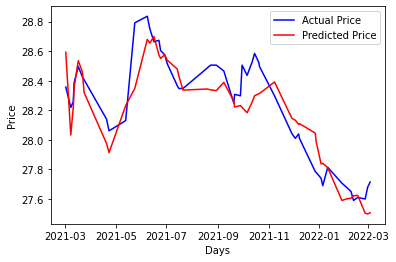

In [72]:
#This graph is with 500 epochs
plot_graph(final_df)

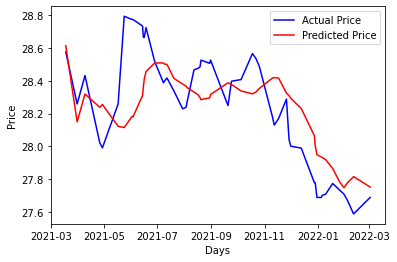

In [58]:
# plot true/pred prices graph/ this graph is with 100 epochs
plot_graph(final_df)

In [73]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

                 open       high        low      close   adjclose  volume  \
2022-01-05  28.000000  28.000000  27.930000  27.950001  27.950001    6100   
2022-01-11  27.820000  27.900999  27.799999  27.840000  27.840000   22200   
2022-01-28  27.590000  27.750000  27.209999  27.702999  27.702999   33600   
2022-02-04  27.700001  27.784000  27.700001  27.738001  27.738001    7000   
2022-02-08  27.629999  27.780001  27.629999  27.775000  27.775000   10700   
2022-02-11  27.730000  27.809000  27.730000  27.740000  27.740000    7100   
2022-02-16  27.705000  27.790001  27.705000  27.735001  27.735001    1000   
2022-02-25  27.639999  27.680000  27.610001  27.680000  27.680000    8400   
2022-02-28  27.670000  27.694000  27.660000  27.672001  27.672001    7500   
2022-03-03  27.590000  27.674000  27.100000  27.650000  27.650000   27200   

           ticker  adjclose_15  true_adjclose_15  buy_profit  sell_profit  
2022-01-05   SPCX    27.841404         27.690001         0.0     0.260000  
